# Session 10: Path-Dependent Volatility and Applications

## Course: Advanced Volatility Modeling

---

## Learning Objectives

1. Understand path-dependent volatility dynamics
2. Implement volatility targeting and risk parity strategies
3. Apply volatility models to VaR and Expected Shortfall
4. Explore volatility in option pricing and the VIX

---

## 1. Path-Dependent Volatility

### 1.1 What is Path Dependence?

Volatility depends not just on the current state but on the **path** of past returns:
- **GARCH**: $\sigma_t$ depends on $\epsilon_{t-1}, \epsilon_{t-2}, ...$
- **HAR**: Uses daily, weekly, monthly averages of RV
- **Regime switching**: Volatility depends on current regime and transition history

### 1.2 Signature of Path Dependence

At-the-money implied volatility responds to:
- Recent realized volatility
- Recent returns (leverage effect)
- Time since last volatility spike

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from arch import arch_model
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
# Download data
spy = yf.download('SPY', start='2010-01-01', end='2024-12-31', progress=False)
vix = yf.download('^VIX', start='2010-01-01', end='2024-12-31', progress=False)

if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.get_level_values(0)
    vix.columns = vix.columns.get_level_values(0)

data = pd.DataFrame({
    'price': spy['Close'],
    'vix': vix['Close']
}).dropna()

data['returns'] = np.log(data['price'] / data['price'].shift(1)) * 100
data['rv_20'] = data['returns'].rolling(20).std() * np.sqrt(252)  # Annualized
data = data.dropna()

print(f"Sample: {data.index[0].date()} to {data.index[-1].date()}")

YF.download() has changed argument auto_adjust default to True
Sample: 2010-02-02 to 2024-12-30


## 2. Volatility Targeting

### 2.1 Concept

Adjust portfolio exposure inversely to volatility:

$$w_t = \frac{\sigma_{target}}{\sigma_t}$$

where $\sigma_{target}$ is the target volatility.

### 2.2 Benefits
- Constant risk contribution
- Reduced drawdowns during crises
- More stable Sharpe ratio

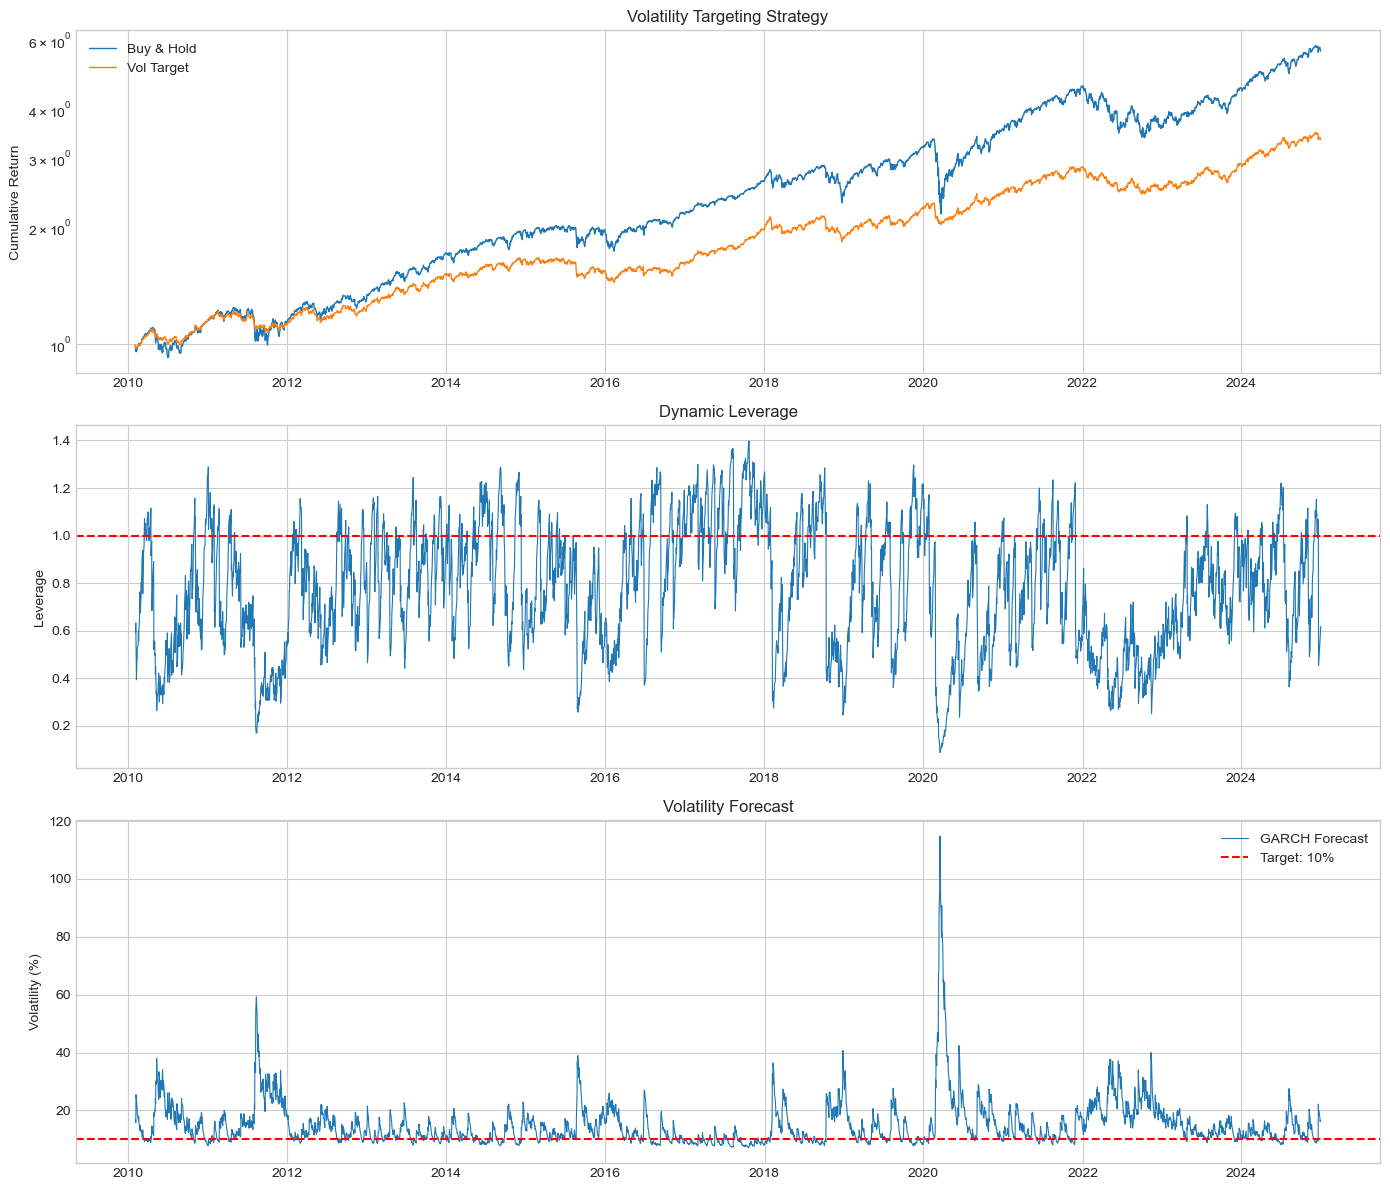


Performance Comparison
Metric                    Buy & Hold      Vol Target
------------------------------------------------------------
Ann. Return (%)                13.09            8.63
Ann. Volatility (%)            17.10           10.09
Sharpe Ratio                    0.77            0.85
Max Drawdown (%)              -41.12          -15.53


In [4]:
def volatility_targeting_strategy(returns, vol_forecast, target_vol=10, max_leverage=2):
    """
    Implement volatility targeting strategy.
    
    Parameters
    ----------
    returns : Series
        Asset returns
    vol_forecast : Series
        Volatility forecast (annualized %)
    target_vol : float
        Target volatility (%)
    max_leverage : float
        Maximum leverage allowed
    """
    # Compute weights
    weights = target_vol / vol_forecast
    weights = weights.clip(0, max_leverage)  # Cap leverage
    
    # Lag weights by 1 day (use yesterday's forecast for today's position)
    weights = weights.shift(1)
    
    # Strategy returns
    strat_returns = weights * returns
    
    return strat_returns, weights

# Fit GARCH for volatility forecast
garch = arch_model(data['returns'], vol='Garch', p=1, q=1)
garch_fit = garch.fit(disp='off')
vol_forecast = garch_fit.conditional_volatility * np.sqrt(252)  # Annualize

# Run strategy
target_vol = 10  # 10% target
strat_returns, weights = volatility_targeting_strategy(
    data['returns'], vol_forecast, target_vol=target_vol
)

# Compare
results = pd.DataFrame({
    'Buy & Hold': data['returns'],
    'Vol Target': strat_returns,
    'Weight': weights
}).dropna()

# Cumulative returns
cum_bh = (1 + results['Buy & Hold']/100).cumprod()
cum_vt = (1 + results['Vol Target']/100).cumprod()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].plot(cum_bh.index, cum_bh, label='Buy & Hold', linewidth=1)
axes[0].plot(cum_vt.index, cum_vt, label='Vol Target', linewidth=1)
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('Volatility Targeting Strategy')
axes[0].legend()
axes[0].set_yscale('log')

axes[1].plot(results['Weight'].index, results['Weight'], linewidth=0.8)
axes[1].axhline(1, color='red', linestyle='--')
axes[1].set_ylabel('Leverage')
axes[1].set_title('Dynamic Leverage')

axes[2].plot(vol_forecast.index, vol_forecast, label='GARCH Forecast', linewidth=0.8)
axes[2].axhline(target_vol, color='red', linestyle='--', label=f'Target: {target_vol}%')
axes[2].set_ylabel('Volatility (%)')
axes[2].set_title('Volatility Forecast')
axes[2].legend()

plt.tight_layout()
plt.show()

# Performance metrics
def performance_metrics(returns):
    ann_ret = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol
    max_dd = (returns.cumsum() - returns.cumsum().cummax()).min()
    return ann_ret, ann_vol, sharpe, max_dd

print("\nPerformance Comparison")
print("="*60)
print(f"{'Metric':<20} {'Buy & Hold':>15} {'Vol Target':>15}")
print("-"*60)

bh_metrics = performance_metrics(results['Buy & Hold'])
vt_metrics = performance_metrics(results['Vol Target'])

for metric, bh, vt in zip(['Ann. Return (%)', 'Ann. Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)'],
                          bh_metrics, vt_metrics):
    print(f"{metric:<20} {bh:>15.2f} {vt:>15.2f}")

## 3. Value at Risk (VaR) and Expected Shortfall

### 3.1 Definitions

**Value at Risk** at confidence level $\alpha$:
$$VaR_\alpha = -\inf\{x : P(R \leq x) \geq 1 - \alpha\}$$

**Expected Shortfall** (Conditional VaR):
$$ES_\alpha = -E[R | R \leq -VaR_\alpha]$$

In [6]:
def garch_var_es(returns, alpha=0.01, window=500):
    """
    Compute rolling VaR and ES using GARCH.
    """
    n = len(returns)
    var_list = []
    es_list = []
    dates = []
    
    for t in range(window, n):
        train = returns.iloc[t-window:t]
        
        try:
            model = arch_model(train, vol='Garch', p=1, q=1, dist='t')
            fit = model.fit(disp='off', show_warning=False)
            
            # 1-day forecast
            forecast = fit.forecast(horizon=1, reindex=False)
            vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0])
            
            # Degrees of freedom
            nu = fit.params.get('nu', 8)
            
            # VaR (Student-t)
            var_t = -stats.t.ppf(alpha, nu) * vol_forecast * np.sqrt((nu-2)/nu)
            
            # ES (Student-t)
            t_alpha = stats.t.ppf(alpha, nu)
            es_t = vol_forecast * np.sqrt((nu-2)/nu) * (
                stats.t.pdf(t_alpha, nu) / alpha * (nu + t_alpha**2) / (nu - 1)
            )
            
            var_list.append(var_t)
            es_list.append(es_t)
            dates.append(returns.index[t])
        except:
            continue
    
    return pd.DataFrame({'VaR': var_list, 'ES': es_list}, index=dates)

# Compute rolling VaR/ES
risk_measures = garch_var_es(data['returns'], alpha=0.01, window=500)

# Align returns
returns_aligned = data['returns'].loc[risk_measures.index]

# Count violations
violations = (returns_aligned < -risk_measures['VaR']).sum()
violation_rate = violations / len(risk_measures) * 100

print(f"VaR Backtest (1% level)")
print(f"="*40)
print(f"Expected violations: 1.00%")
print(f"Actual violations: {violation_rate:.2f}%")
print(f"Number of violations: {violations} / {len(risk_measures)}")

VaR Backtest (1% level)
Expected violations: 1.00%
Actual violations: 1.44%
Number of violations: 47 / 3253


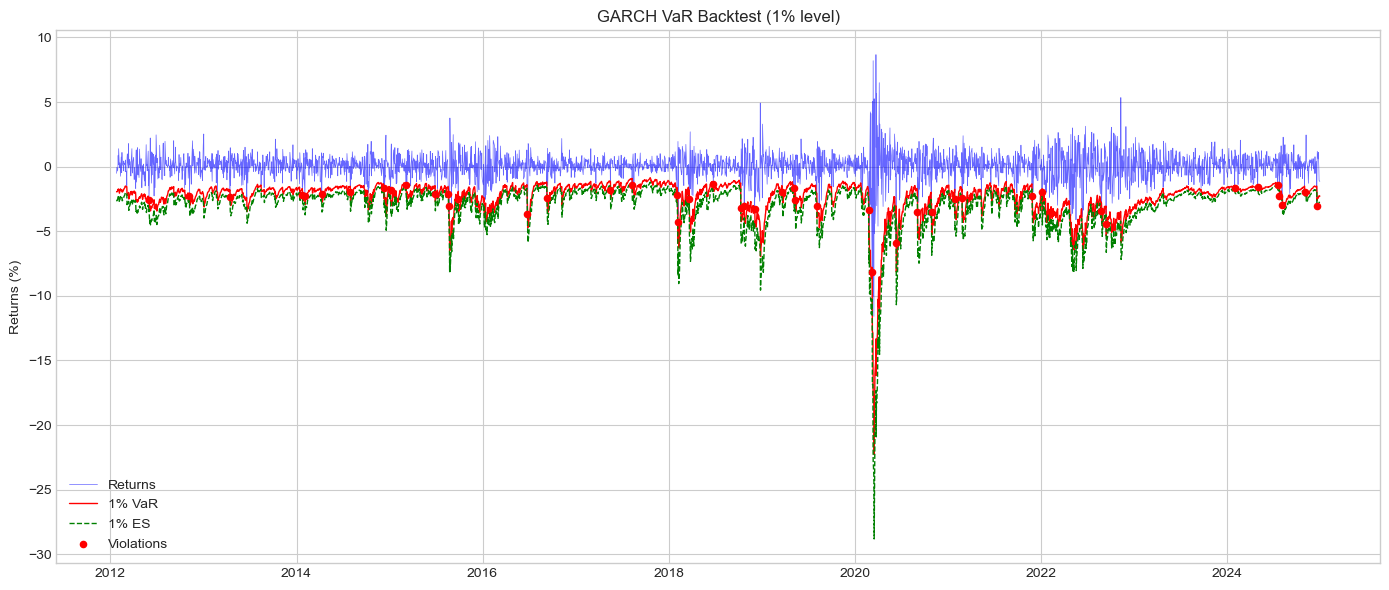

In [7]:
# Plot VaR backtest
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(returns_aligned.index, returns_aligned, 'b-', linewidth=0.5, alpha=0.6, label='Returns')
ax.plot(risk_measures.index, -risk_measures['VaR'], 'r-', linewidth=1, label='1% VaR')
ax.plot(risk_measures.index, -risk_measures['ES'], 'g--', linewidth=1, label='1% ES')

# Mark violations
violations_mask = returns_aligned < -risk_measures['VaR']
ax.scatter(returns_aligned[violations_mask].index, 
           returns_aligned[violations_mask], 
           color='red', s=20, zorder=5, label='Violations')

ax.set_ylabel('Returns (%)')
ax.set_title('GARCH VaR Backtest (1% level)')
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

## 4. VIX and Implied Volatility

### 4.1 VIX Index

The VIX measures 30-day implied volatility from S&P 500 options:

$$VIX^2 = \frac{2}{T} \sum_i \frac{\Delta K_i}{K_i^2} e^{rT} Q(K_i) - \frac{1}{T}\left(\frac{F}{K_0} - 1\right)^2$$

### 4.2 VIX-Realized Volatility Spread

The **Variance Risk Premium (VRP)**:
$$VRP = E^Q[RV] - E^P[RV] = IV^2 - E^P[RV]$$

On average, VRP > 0: Investors pay a premium for volatility protection.

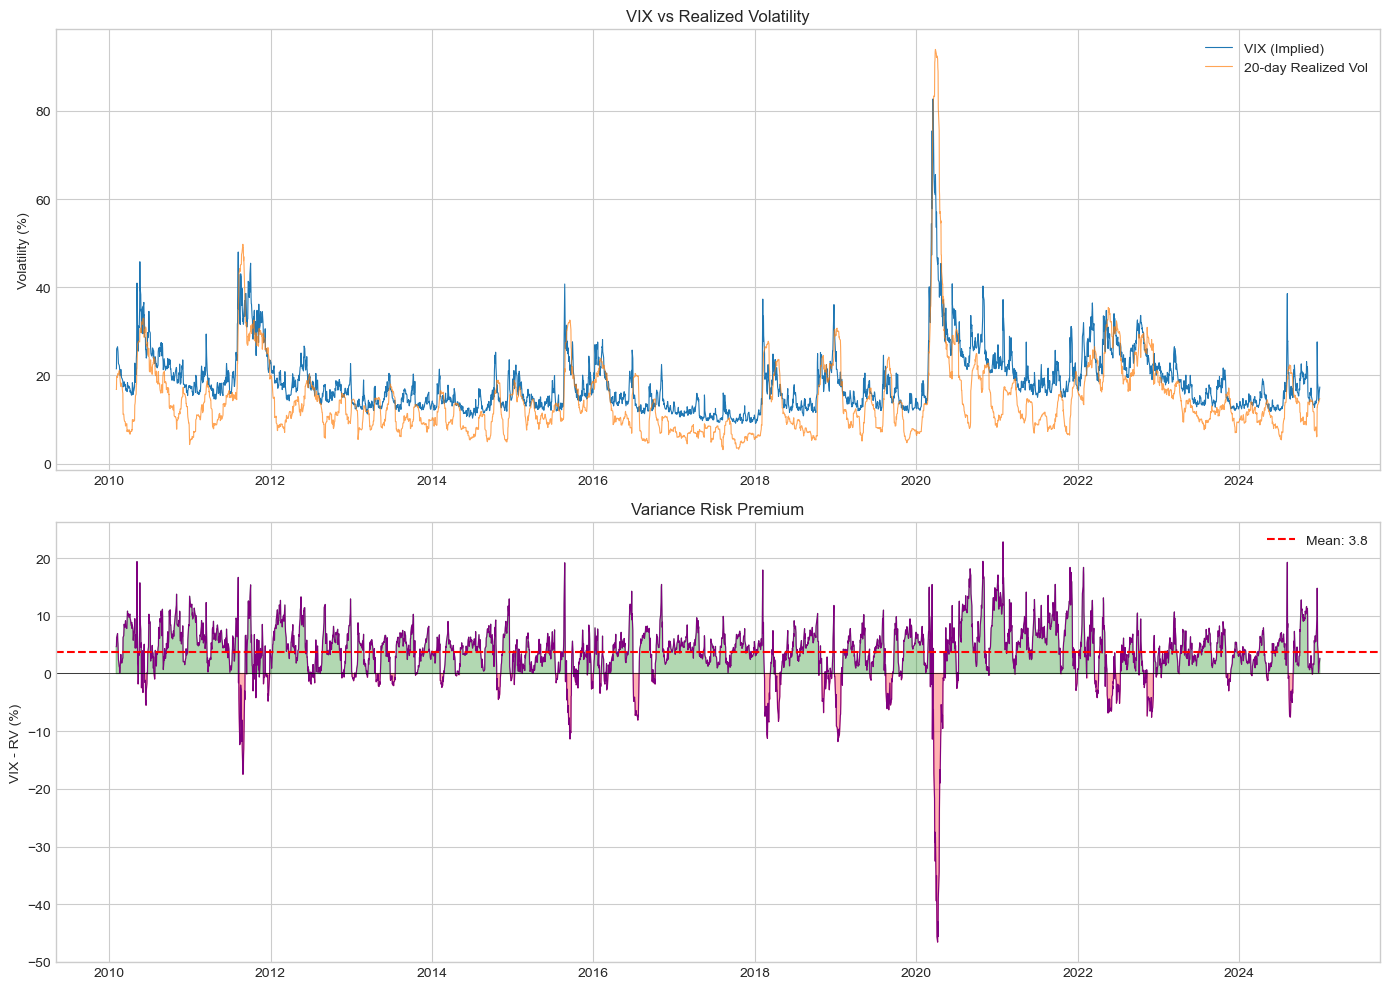


Variance Risk Premium Statistics:
Mean: 3.76%
% Positive: 85.3%

On average, VIX exceeds realized vol by 3.8 percentage points.


In [9]:
# VIX vs Realized Volatility
data['rv_30_fwd'] = data['returns'].rolling(22).std().shift(-22) * np.sqrt(252)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series
axes[0].plot(data.index, data['vix'], label='VIX (Implied)', linewidth=0.8)
axes[0].plot(data.index, data['rv_20'], label='20-day Realized Vol', linewidth=0.8, alpha=0.7)
axes[0].set_ylabel('Volatility (%)')
axes[0].set_title('VIX vs Realized Volatility')
axes[0].legend()

# Variance Risk Premium
vrp = data['vix'] - data['rv_20']
axes[1].plot(vrp.index, vrp, linewidth=0.8, color='purple')
axes[1].axhline(vrp.mean(), color='red', linestyle='--', label=f'Mean: {vrp.mean():.1f}')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].fill_between(vrp.index, 0, vrp, where=vrp>0, alpha=0.3, color='green')
axes[1].fill_between(vrp.index, 0, vrp, where=vrp<0, alpha=0.3, color='red')
axes[1].set_ylabel('VIX - RV (%)')
axes[1].set_title('Variance Risk Premium')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nVariance Risk Premium Statistics:")
print(f"Mean: {vrp.mean():.2f}%")
print(f"% Positive: {(vrp > 0).mean()*100:.1f}%")
print(f"\nOn average, VIX exceeds realized vol by {vrp.mean():.1f} percentage points.")

## 5. Volatility Trading Strategies

### 5.1 Sell Volatility (Variance Swap)

Profit from VRP by selling variance:
- Short VIX futures / options
- Short variance swaps
- Short straddles

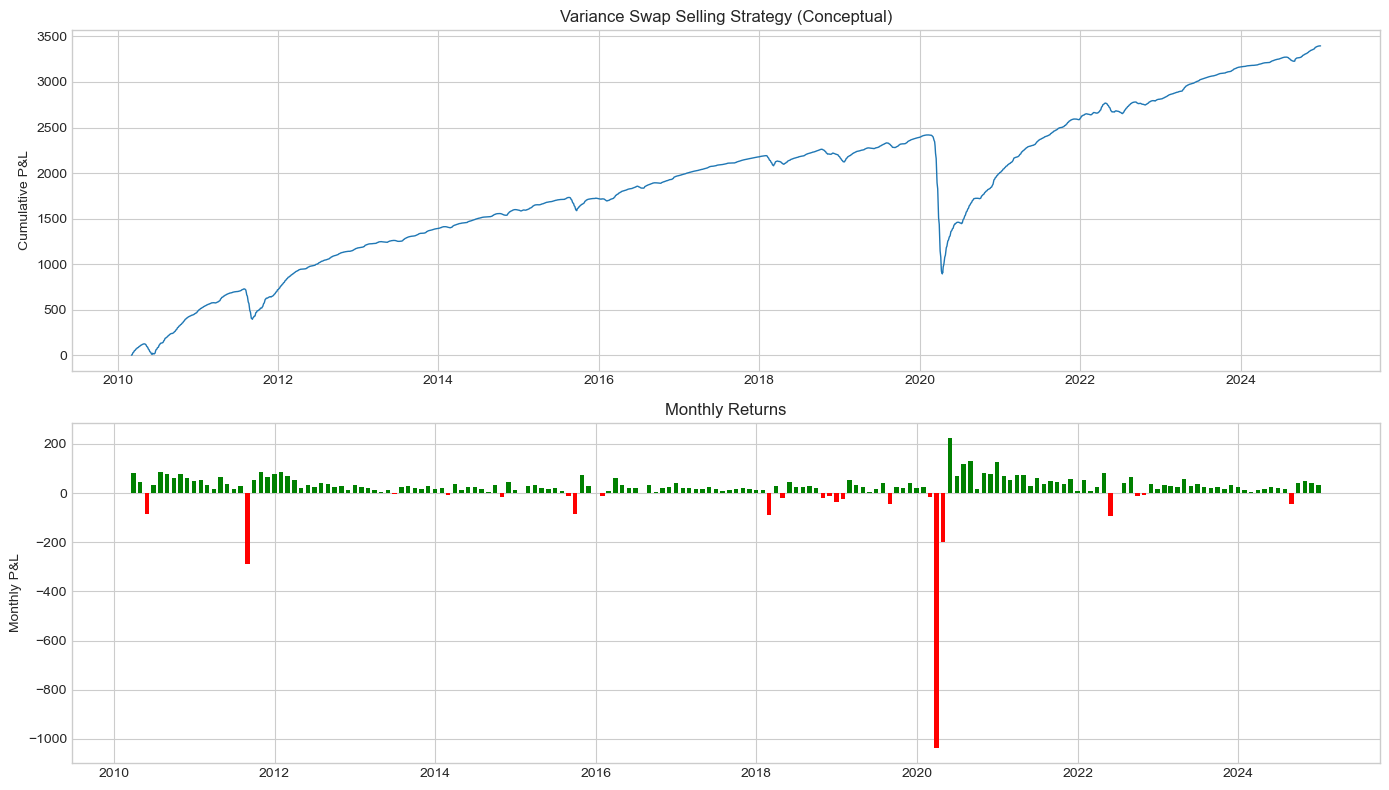


Variance Selling Strategy:
Win rate: 82.8%
Average daily P&L: 0.9099
Sharpe ratio: 2.43


In [11]:
# Simple variance selling strategy (conceptual)
# P&L ≈ VIX² - RV² (for variance swap)

data['vix_lag'] = data['vix'].shift(22)  # Entry VIX
data['variance_swap_pnl'] = (data['vix_lag']**2 - data['rv_20']**2) / 100  # Scaled

var_swap_returns = data['variance_swap_pnl'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Cumulative P&L
axes[0].plot(var_swap_returns.index, var_swap_returns.cumsum(), linewidth=1)
axes[0].set_ylabel('Cumulative P&L')
axes[0].set_title('Variance Swap Selling Strategy (Conceptual)')

# Monthly returns
monthly_pnl = var_swap_returns.resample('M').sum()
axes[1].bar(monthly_pnl.index, monthly_pnl.values, width=20, 
            color=['green' if x > 0 else 'red' for x in monthly_pnl.values])
axes[1].set_ylabel('Monthly P&L')
axes[1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()

print("\nVariance Selling Strategy:")
print(f"Win rate: {(var_swap_returns > 0).mean()*100:.1f}%")
print(f"Average daily P&L: {var_swap_returns.mean():.4f}")
print(f"Sharpe ratio: {var_swap_returns.mean() / var_swap_returns.std() * np.sqrt(252):.2f}")

## 6. Course Summary

### Key Models Covered

| Session | Topic | Key Models |
|---------|-------|------------|
| 1 | Foundations | Stylized facts, simple estimators |
| 2 | GARCH | ARCH, GARCH, IGARCH |
| 3 | Asymmetric | GJR-GARCH, EGARCH, TGARCH |
| 4 | Advanced | FIGARCH, APARCH, Component |
| 5 | Realized | RV, BV, TSRV, Realized Kernel |
| 6 | HAR | HAR-RV, HAR-CJ, HAR-RS |
| 7 | Stochastic | SV, Heston |
| 8 | Rough | fBM, Rough Bergomi |
| 9 | Multivariate | DCC, BEKK |
| 10 | Applications | Vol targeting, VaR, VRP |

## Final Exercises

1. **Comprehensive Project**: Build a complete volatility forecasting system that:
   - Compares GARCH, HAR, and rough volatility models
   - Evaluates forecasts using multiple metrics
   - Applies to portfolio risk management

2. **Cryptocurrency Volatility**: Apply all course methods to Bitcoin/Ethereum and document differences from equities

3. **Option Pricing**: Implement and compare option prices from Heston vs rough Bergomi

4. **VIX Trading**: Design and backtest a VIX-based trading strategy using HAR forecasts

5. **Multivariate Risk**: Build a DCC-based risk system for a multi-asset portfolio

## References (Course-Wide)

### Textbooks
1. Tsay, R. S. (2010). *Analysis of Financial Time Series*. Wiley.
2. Francq, C., & Zakoian, J. M. (2019). *GARCH Models*. Wiley.
3. Gatheral, J. (2006). *The Volatility Surface*. Wiley.

### Key Papers
1. Bollerslev (1986) - GARCH
2. Nelson (1991) - EGARCH
3. Engle (2002) - DCC
4. Corsi (2009) - HAR
5. Gatheral et al. (2018) - Rough Volatility

### Software
- Python: `arch`, `statsmodels`, `scipy`
- R: `rugarch`, `rmgarch`